In [55]:
from importlib import reload  # Python 3.4+
import helper.helper as h
h = reload(h)

length, n = 500, 7
h.length, h.n = length, n

In [56]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize 
from operator import itemgetter

## Generate $n$D data

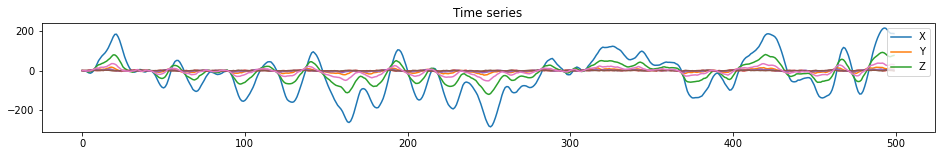

[[1.01819236e+04 5.91208372e+02 4.16666091e+03 5.87876967e+01
  1.96600761e+02 4.65881453e-01 1.62765276e+03]
 [5.91208372e+02 6.10198084e+01 2.86013395e+02 9.08400717e+00
  2.52326248e+01 2.09923677e+00 1.34347605e+02]
 [4.16666091e+03 2.86013395e+02 1.79609635e+03 3.18245194e+01
  1.02204628e+02 2.55425726e+00 7.40896802e+02]
 [5.87876967e+01 9.08400717e+00 3.18245194e+01 3.33563309e+00
  4.73020335e+00 9.36497219e-01 1.73551319e+01]
 [1.96600761e+02 2.52326248e+01 1.02204628e+02 4.73020335e+00
  1.30854796e+01 1.52659830e+00 5.19338581e+01]
 [4.65881453e-01 2.09923677e+00 2.55425726e+00 9.36497219e-01
  1.52659830e+00 1.55412479e+00 2.76364462e+00]
 [1.62765276e+03 1.34347605e+02 7.40896802e+02 1.73551319e+01
  5.19338581e+01 2.76364462e+00 3.26104258e+02]]
Actual A:
 [[0.6 0.  0.  0.  0.  0.  0. ]
 [0.6 0.6 0.  0.  0.  0.  0. ]
 [0.6 0.6 0.6 0.  0.  0.  0. ]
 [0.6 0.6 0.6 0.6 0.  0.  0. ]
 [0.6 0.6 0.6 0.6 0.6 0.  0. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0. ]
 [0.6 0.6 0.6 0.6 0.6 0.6 0.6]]


In [57]:
# np.random.seed(seed = 1)

## A matrix

# random matrix A
# A = np.tril(np.random.rand(n, n)) # random non-strict LT A
A = h.a_list_to_a_matrix(0.6 * np.ones(int(n * (n + 1) / 2))) # strict LT A with fixed 0.8s

## Permutation matrix
P = np.identity(n) # identity matrix
P = np.array(list(itertools.permutations(np.identity(n)))[np.random.choice(len(list(itertools.permutations(np.identity(n)))))]) # random permutation matrix

# Generate nD data
series = h.generate_var_data(length, n, A, P)
h.series = series

# Plot
plt.figure(figsize=(16,2))
plt.title("Time series")
plots = plt.plot(series)
plt.legend(plots, ["X", "Y", "Z"], loc=1)
plt.show()

print(np.cov(series.transpose()))
print("Actual A:\n", A)
print("\nActual P:\n", P)

### Cost functions for $n$D
\begin{align*} C_1 &= \left \lVert X - P^{-1}AP X \right \rVert_2^2,\\
C_2 &= \left \lVert X - P^{T}AP X \right \rVert_2^2,\\
C_3 &= \left \lVert X - \frac{P^{T}AP}{\text{det} P} X \right \rVert_2^2. \end{align*}

In [173]:
# convert A to only the parameters
a_list = A[np.tril_indices(n, - 1)]
p_list = np.array([row[:n - 1] for row in P[:n - 1]])

print("C_1(P*, A*):\n", h.C_1(np.append(p_list, a_list)))
print("C_2(P*, A*):\n", h.C_2(np.append(p_list, a_list)))
print("C_3(P*, A*):\n", h.C_3(np.append(p_list, a_list)))

C_1(P*, A*):
 3.0820373778910937
C_2(P*, A*):
 3.0820373778910937
C_3(P*, A*):
 3.0820373778910937


### Constraints for $n$D

In [58]:
a_parms = int(n * (n + 1) / 2)
p_parms = int((n - 1) ** 2)
tot_parms = a_parms + p_parms

# n dimensional constraints
# entries must be between 0 and 1
V = np.identity(tot_parms)[:p_parms,]  # 0 <= p <= 1 for all p

# sum excl. last entry must be between 0 and 1 for each row
for i in range(n - 1):
    row = np.append(np.zeros((n - 1) * i), np.ones(n - 1))
    row = np.append(row, np.zeros((n - 1 - i - 1) * (n - 1)))
    row = np.append(row, np.zeros(a_parms))   # sum(row(1)) = 1
    V = np.vstack((V, row))
    
# column excl. last entry must be between 0 and 1 for each row
for i in range(n - 1):
    col = np.append(1, np.zeros(n - 2))
    col = np.tile(col, (n - 1))
    col = np.append(np.zeros(i), col)
    col = np.append(col, np.zeros(a_parms - i))
    V = np.vstack((V, col))
    
# bottom row must sum to one
b_row = np.append(np.ones(p_parms), np.zeros(a_parms))

# create constraints, lower, and upper bounds
V = np.vstack((V, b_row))
L = np.append(np.zeros(p_parms + (n - 1) + (n - 1)), n - 2)
U = np.append(np.ones(p_parms + (n - 1) + (n - 1)), n - 1)

In [66]:
outcome = []

for _ in range(5):
    init_parm = np.random.rand(tot_parms)
    print(P[:n-1,:n-1].flatten())
    init_parm[:p_parms] = P[:n-1,:n-1].flatten()
    # minimize, starting from a random entry
    results = optimize.minimize(h.C_var_1, init_parm, constraints = optimize.LinearConstraint(V, L, U)).x

    # get results
    P_DS_out = h.p_list_to_p_matrix(results[:p_parms])
    P_perm_out = h.closest_perm(np.round(h.p_list_to_p_matrix(results[:p_parms]), 2))
    
    A_out = h.a_list_to_a_matrix(results[p_parms:])
    
    B = np.matmul(np.linalg.inv(P), np.matmul(A, P))
    B_out = np.matmul(np.linalg.inv(P_DS_out), np.matmul(A_out, P_DS_out))
    
    print("P_DS:\n", np.round(P_DS_out, 2))
    print("B:\n", np.round(B_out, 3))
    print("B*:\n", B)
    # print(A_out, P_DS_out)
    
    outcome.append([P_perm_out, np.linalg.norm(P_DS_out - P_perm_out, ord='fro'), np.linalg.norm(B_out - B, ord='fro'), h.C_var_1(results)])
    print("Total cost value:", h.C_var_1(results))
    
    # print(P_perm_out)
    # print(round(np.linalg.norm(P_DS_out - P_perm_out, ord='fro'), 3))

outcome = sorted(outcome, key=itemgetter(3))

for elem in outcome:
    print("P:", elem[0])
    print("Frob norm of P_DS and P_perm:\n", elem[1])
    print("Frob norm of B and B*:\n", elem[2])

print("\nActual P:\n", P)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
P_DS:
 [[ 0.   -0.    0.    0.22  0.    0.78  0.  ]
 [ 0.    0.   -0.    0.62  0.35  0.02  0.  ]
 [ 0.    0.21  0.    0.13  0.54  0.12 -0.  ]
 [ 0.    0.64  0.01  0.    0.11  0.04  0.2 ]
 [-0.    0.15  0.11  0.02  0.    0.05  0.66]
 [ 0.07  0.    0.88  0.    0.   -0.    0.06]
 [ 0.93  0.   -0.   -0.    0.    0.    0.07]]
B:
 [[ 0.593  0.58   0.626  0.558  0.617  0.674  0.584]
 [-0.     0.599  0.005  0.544  0.64   0.636 -0.013]
 [-0.002  0.593  0.603  0.612  0.6    0.556  0.605]
 [-0.     0.001  0.003  0.573  0.011  0.542 -0.001]
 [ 0.    -0.01  -0.002  0.581  0.633  0.58   0.007]
 [ 0.    -0.003 -0.     0.047 -0.006  0.591 -0.   ]
 [ 0.002  0.595 -0.003  0.651  0.585  0.635  0.602]]
B*:
 [[0.6 0.6 0.6 0.6 0.6 0.6 0.6]
 [0.  0.6 0.  0.6 0.6 0.6 0. ]
 [0.  0.6 0.6 0.6 0.6 0.6 0.6]
 [0.  0.  0.  0.6 0.  0.6 0. ]
 [0.  0.  0.  0.6 0.6 0.6 0. ]
 [0.  0.  0.  0.  0.  0.6 0. ]
 [0.  

In [202]:
a_parms = int(n * (n + 1) / 2 - n)
p_parms = int((n - 1) ** 2)
tot_parms = a_parms + p_parms

# n dimensional constraints
# entries must be between 0 and 1
V = np.identity(tot_parms)[:p_parms,]  # 0 <= p <= 1 for all p

# sum excl. last entry must be between 0 and 1 for each row
for i in range(n - 1):
    row = np.append(np.zeros((n - 1) * i), np.ones(n - 1))
    row = np.append(row, np.zeros((n - 1 - i - 1) * (n - 1)))
    row = np.append(row, np.zeros(a_parms))   # sum(row(1)) = 1
    V = np.vstack((V, row))
    
# column excl. last entry must be between 0 and 1 for each row
for i in range(n - 1):
    col = np.append(1, np.zeros(n - 2))
    col = np.tile(col, (n - 1))
    col = np.append(np.zeros(i), col)
    col = np.append(col, np.zeros(a_parms - i))
    V = np.vstack((V, col))
    
# bottom row must sum to one
b_row = np.append(np.ones(p_parms), np.zeros(a_parms))

# create constraints, lower, and upper bounds
V = np.vstack((V, b_row))
L = np.append(np.zeros(p_parms + (n - 1) + (n - 1)), n - 2)
U = np.append(np.ones(p_parms + (n - 1) + (n - 1)), n - 1)

np.random.seed(seed = 1)

outcome = []

for _ in range(3):
    # minimize, starting from a random entry
    results = optimize.minimize(C_nd_3, np.ones(tot_parms) / n + np.random.rand(tot_parms) / n, constraints = optimize.LinearConstraint(V, L, U)).x

    # get results
    P_DS_out = p_list_to_p_matrix(results[:p_parms])
    P_perm_out = closest_perm_1(np.round(p_list_to_p_matrix(results[:p_parms]), 2))
    
    A_out = a_list_to_a_matrix_LT(results[p_parms:])
    
    print(A_out)
    print(np.round(P_DS_out, 2))
    print("B:\n", np.round(np.matmul(np.linalg.inv(P_DS_out), np.matmul(A_out, P_DS_out)), 3))
    print("B*:\n", np.matmul(np.linalg.inv(P), np.matmul(A, P)))
    # print(A_out, P_DS_out)
    
    outcome.append([P_perm_out, np.linalg.norm(P_DS_out - P_perm_out, ord='fro')])
    print("Total cost value:", C_nd_3(results))
    
    print(P_perm_out)
    # print(round(np.linalg.norm(P_DS_out - P_perm_out, ord='fro'), 3))

outcome = sorted(outcome, key=itemgetter(1))

for elem in outcome:
    print("P:", elem[0])
    print("Cost:\n", elem[1])

print("\nActual P:\n", P)

[[ 0.          0.          0.        ]
 [ 0.07926901  0.          0.        ]
 [-0.0734512   0.01554109  0.        ]]
[[0.09 0.91 0.  ]
 [0.43 0.09 0.48]
 [0.48 0.   0.52]]
B:
 [[-0.513 -8.84   0.455]
 [ 0.053  0.914 -0.047]
 [ 0.467  7.933 -0.401]]
B*:
 [[0.  0.  0. ]
 [0.8 0.  0.8]
 [0.8 0.  0. ]]
Total cost value: 0.47439272638156266
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[ 0.          0.          0.        ]
 [-0.00031775  0.          0.        ]
 [ 0.00325179 -0.0033231   0.        ]]
[[0.2  0.52 0.28]
 [0.23 0.48 0.29]
 [0.57 0.   0.43]]
B:
 [[-0.109 -0.323 -0.163]
 [-0.036 -0.107 -0.054]
 [ 0.145  0.43   0.216]]
B*:
 [[0.  0.  0. ]
 [0.8 0.  0.8]
 [0.8 0.  0. ]]
Total cost value: 0.5883881717141666
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]
[[ 0.          0.          0.        ]
 [-0.00146557  0.          0.        ]
 [-0.05111359  0.05065225  0.        ]]
[[0.2  0.49 0.31]
 [0.19 0.51 0.31]
 [0.61 0.   0.39]]
B:
 [[-0.101 -0.238 -0.153]
 [-0.059 -0.142 -0.091]
 [ 0.159  0.38   0.243]]

### All required constraints in 3D

## Generate a Doubly Stochastic Matrix

In [10]:
def gen_P(n):
    P = np.random.random((n, n))
    rsum, csum = 0, 0

    # Sinkhorn balancing from a random matrix
    while (np.any(np.round(rsum, 3) != 1)) | (np.any(np.round(csum, 3) != 1)):
        P /= P.sum(0)
        P = P / P.sum(1)[:, np.newaxis]
        rsum = P.sum(1)
        csum = P.sum(0)
        
    return P

In [141]:
Sigma = np.identity(n)

def expected_cost(A, P, As, Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

def expected_cost(B, Bs):
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    print(covariance_X)
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

B = np.array([[0, 0.451], [0., 0.]])
Bs = np.array([[0, 0], [0.6, 0.0]])

print(expected_cost(B, Bs))

[[1.   0.  ]
 [0.   1.36]]
2.63662536


In [32]:
def B_cost(B):
    cost = 0

    for t in range(1, length):
        val = series[t]
        est = np.matmul(B, series[t - 1])
        cost += np.linalg.norm(val - est, ord = 2) ** 2

    return cost / (length - 1) # regularization

B = np.array([[0.8, 0.0, 0.0], [0.8, 0.8, 0.0], [0.8, 0.8, 0.8]])
# B = np.array([[ 0.003,  0.024, -0.008], [ 0.003,  0.009,  0.003], [ 0.011, -0.004,  0.028]])
print(B_cost(B))

6.849591460130997


In [36]:
P_inv = np.linalg.inv(P)
B = np.matmul(P_inv, np.matmul(A, P))
print(B)
print(B_cost(B))
print(h.C_1(np.array([0, 0.451])))

[[0.8 0.  0.8]
 [0.8 0.8 0.8]
 [0.  0.  0.8]]
7.052586063837533


ValueError: cannot reshape array of size 2 into shape (2,2)